## Motif Detection
### Stellina Ao, 10.13.2024 - 
The purpose of this code is to detect hippocampal motifs in data collected by the Allen Institute.

#### Read in Data

In [25]:
from pynwb import NWBHDF5IO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.signal import find_peaks

import warnings
warnings.filterwarnings("ignore")

In [26]:
io = NWBHDF5IO('..\..\..\Data\sub-699733573_ses-715093703.nwb', mode="r", load_namespaces=True)
nwb = io.read()
units_raw = nwb.units
col_names = list(units_raw[0])
electrodes = nwb.electrodes
#where(nwb.electrodes['location'][:] == 'CA1')

Isolate CA1

In [27]:
units = []

for i in range(len(units_raw)):
    peak_id = units_raw.peak_channel_id[i] # unit id --> electrode id
    location_id = np.where(electrodes.id[:]==peak_id)[0] # electrode id --> location index
    location_name = str(electrodes['location'][location_id])[2:-2] # location index --> location name

    if location_name == "CA1":
        units_i = units_raw[i].values.tolist()[0]
        units.append(units_i)
    

In [28]:
units = pd.DataFrame(units, columns=col_names)
units

,snr,quality,presence_ratio,spread,cumulative_drift,isolation_distance,amplitude,firing_rate,nn_hit_rate,isi_violations,...,waveform_duration,local_index,max_drift,velocity_above,cluster_id,peak_channel_id,d_prime,spike_times,spike_amplitudes,waveform_mean
0,0.687018,good,0.99,70.0,271.10,33.479409,61.960470,1.565634,0.905747,0.310864,...,0.590620,260,42.01,-4.120603,265,850261536,2.387209,"[26.908732319847136, 26.942132339083205, 27.05...","[0.00017656975767591697, 0.0001835135453297648...","[[0.0, 1.2983100000000043, 0.3116100000000044,..."
1,0.673635,good,0.99,140.0,430.79,46.831376,74.353500,5.461426,0.875333,0.569012,...,0.288442,254,60.55,-0.255085,259,850261536,3.465030,"[28.553666600547295, 29.755900626283143, 34.18...","[7.420453512439336e-05, 8.028774640024058e-05,...","[[0.0, 2.1996, 1.9340099999999953, 4.520489999..."
2,0.781988,noise,0.99,170.0,1159.80,26.258185,34.126560,2.567612,0.172370,0.783167,...,1.304858,269,43.68,-2.380793,274,850261586,1.885486,"[27.67583276164321, 28.614566635621447, 29.292...","[2.8210468774681967e-05, 2.869446163639047e-05...","[[0.0, -0.5576999999999881, -1.174289999999997..."
3,0.742034,noise,0.99,170.0,519.61,51.070568,32.517810,3.829626,0.632667,0.253935,...,2.128978,268,20.99,-0.343384,273,850261586,1.592041,"[27.173265805533212, 27.564432697484584, 27.64...","[3.064122959397851e-05, 2.7324892419016626e-05...","[[0.0, 1.0756200000000113, 0.3884400000000081,..."
4,1.325109,good,0.99,100.0,362.32,55.840347,49.563150,1.974938,0.919333,0.640174,...,0.796650,274,24.60,-1.522334,279,850261592,4.370831,"[27.466199307575707, 27.685499433877204, 27.73...","[3.924999324486202e-05, 5.473287702446116e-05,...","[[0.0, 0.39234000000000613, -0.726179999999979..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,2.345899,good,0.99,80.0,141.83,56.530776,111.524400,1.479844,0.935185,0.179687,...,1.002680,157,38.35,1.373534,158,850264602,4.765335,"[32.170202081003964, 32.17376875352498, 32.178...","[0.00014207136713815578, 0.0001790785914730432...","[[0.0, 1.6442399999999502, 1.2277199999999766,..."
555,1.271622,good,0.99,150.0,131.85,80.263176,55.918005,9.726302,0.982000,0.066092,...,0.247236,156,46.48,0.721106,157,850264602,3.944670,"[29.152030460302925, 29.320030736058992, 29.59...","[6.562606893581982e-05, 5.59735900921398e-05, ...","[[0.0, -0.87808500000002, -0.7423650000000208,..."
556,0.913914,noise,0.99,170.0,415.50,25.774534,50.753235,2.000810,0.129794,7.415891,...,1.703183,177,27.17,0.263261,178,850264614,2.218163,"[29.298164033500267, 29.307430715377286, 29.30...","[5.088219614646396e-05, 4.904580286344289e-05,...","[[0.0, 0.28879500000001457, 1.3484249999999562..."
557,1.352460,noise,0.99,120.0,182.54,42.792665,67.982655,4.380738,0.719086,1.205220,...,0.274707,176,43.17,0.206030,177,850264614,3.228380,"[28.979796844264907, 29.120563741986707, 29.21...","[6.55700516977504e-05, 7.993237837305242e-05, ...","[[0.0, -2.3667150000000454, -0.897195000000042..."


In [29]:
unitSpikeTimes_raw = units["spike_times"]
print(np.shape(unitSpikeTimes_raw))
unitSpikeTimes_raw[0]

(559,)


array([  26.90873232,   26.94213234,   27.05559907, ..., 9563.01976611,
       9573.10417099, 9573.11063766])

#### Convert Spike Times to Spike Trains

In [30]:
unitSpikeTimes = [np.round(unitSpikeTimes_raw[i], 3) for i in range(len(unitSpikeTimes_raw))] # seconds
unitSpikeTimes[0]

array([  26.909,   26.942,   27.056, ..., 9563.02 , 9573.104, 9573.111])

In [31]:
unitSpikeTimes_whole = [np.unique([int(unitSpikeTimes[i][j] * 1e3) for j in range(len(unitSpikeTimes[i]))]) for i in range(len(unitSpikeTimes))] # ms
unitSpikeTimes_whole[0]

array([  26909,   26942,   27056, ..., 9563020, 9573104, 9573111])

NOTE: now, 1 s = 1000 indices; 1 ms = 1e-3 s = 1 index

In [32]:
def spikeTime2Train(spikeTimes):
    if spikeTimes[0] == 0:
        spikeTimes = spikeTimes[1:len(spikeTimes)] # get rid of first 0, will cause problems in code
    
    length = int(spikeTimes[-1])    
    spikeTrains = np.zeros(length)
    k = 0
    
    for j in range(1,length+1):
        if spikeTimes[k] == j:
            spikeTrains[j-1] = 1
            k+=1
    
    return spikeTrains

def spikeTimes2Trains(spikeTimesArr, n=3):
    spikeTrains = []
    for i in range(n):
        print(i)
        spikeTrains.append(spikeTime2Train(spikeTimesArr[i]))
    return spikeTrains

In [33]:
spikeTrains = spikeTimes2Trains(unitSpikeTimes_whole)

0
1
2


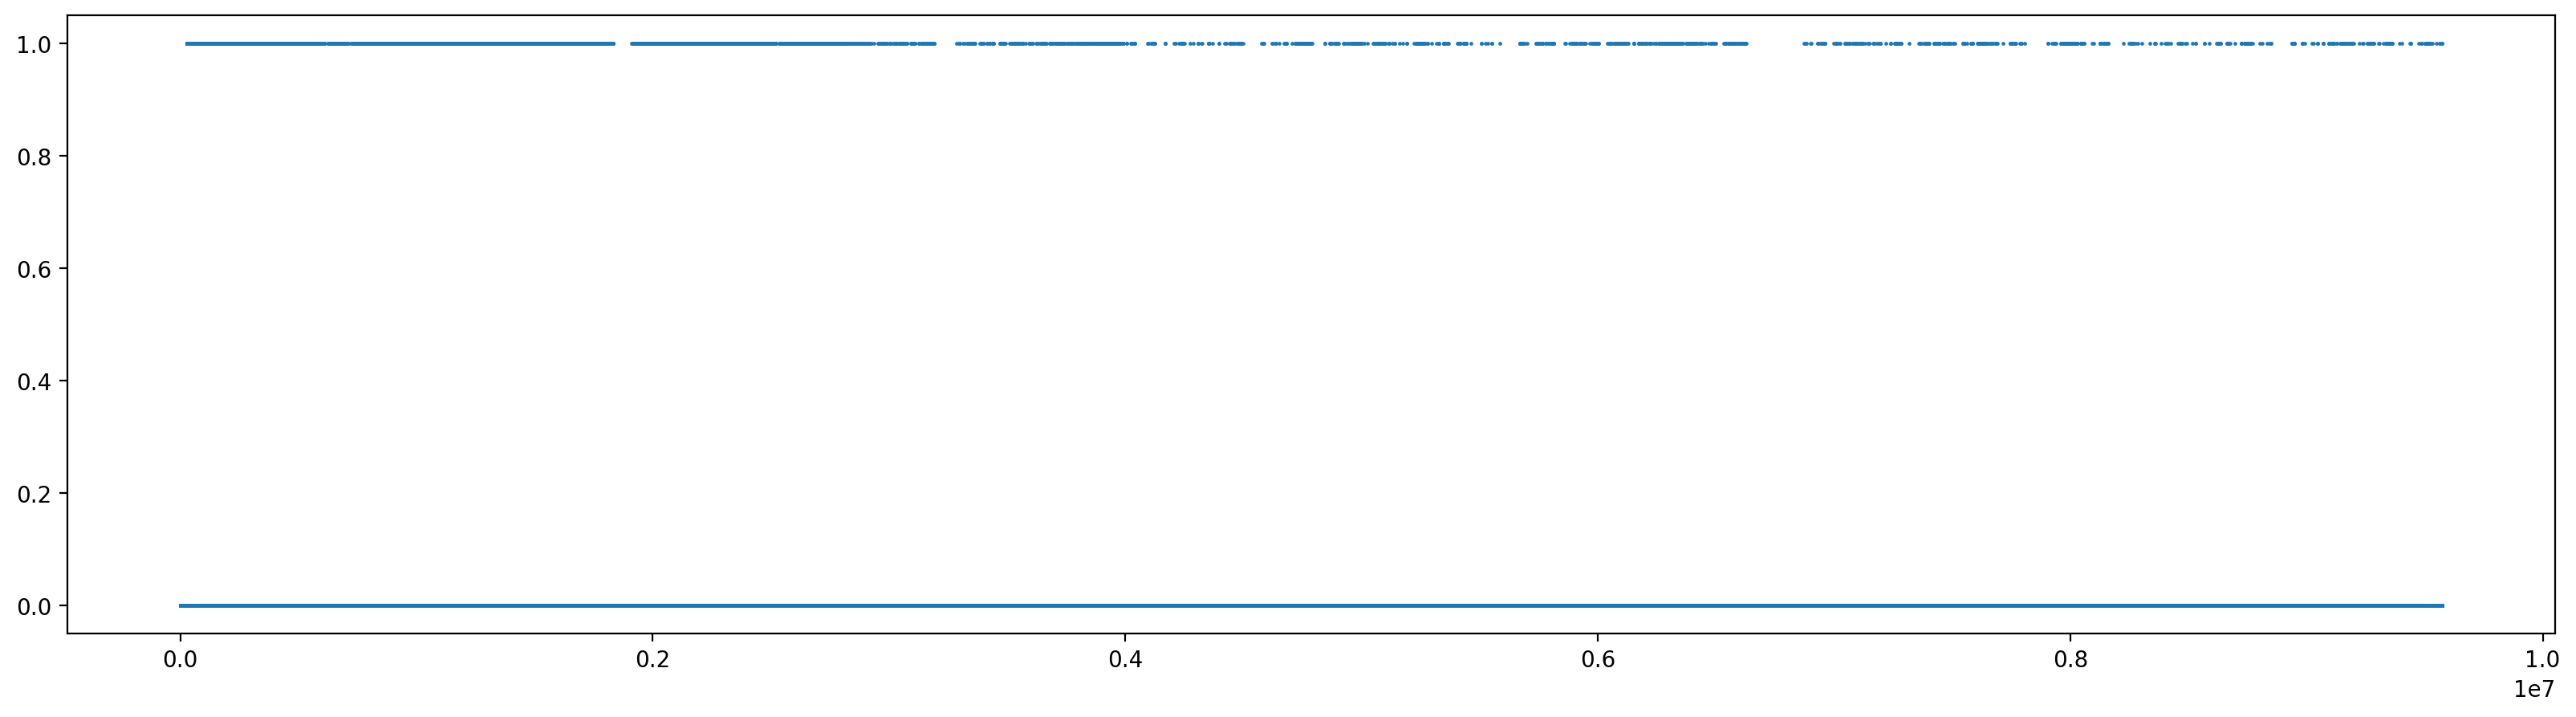

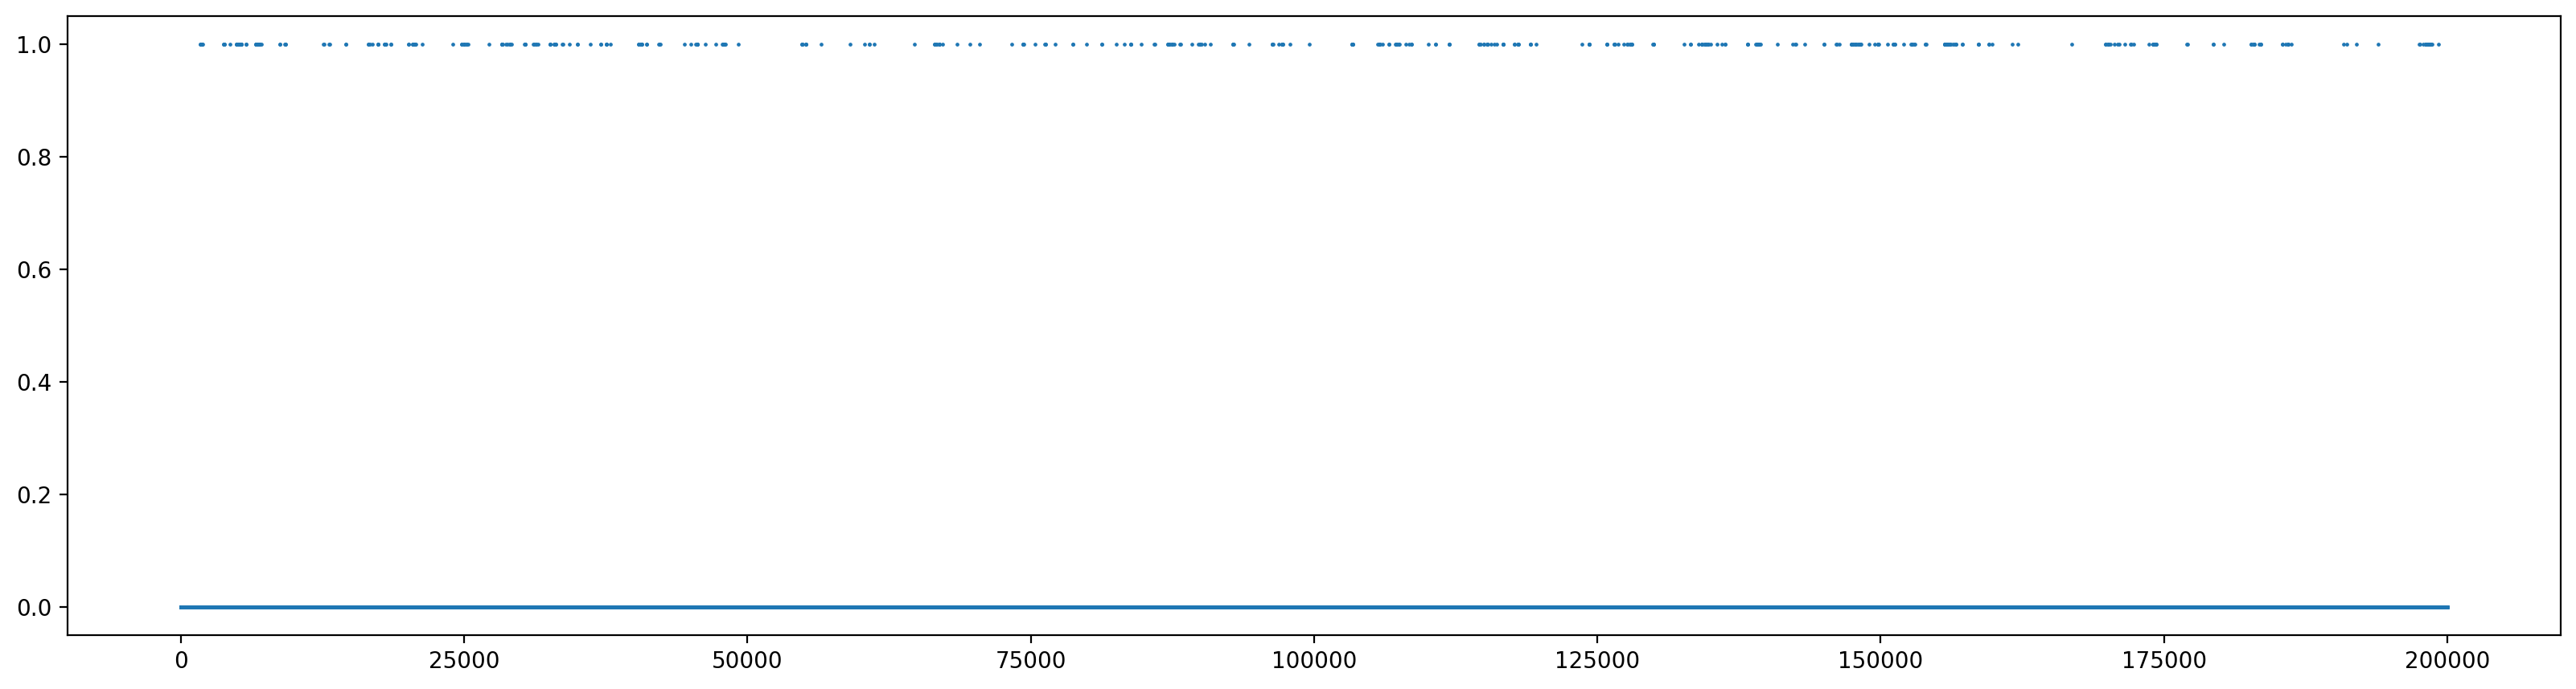

In [34]:
plt.figure(figsize=(20, 5), dpi = 200)
plt.scatter(range(len(spikeTrains[0])), spikeTrains[0], s=0.5)
plt.figure(figsize=(20, 5), dpi = 200)
plt.scatter(range(len(spikeTrains[0][2000000:2200000])), spikeTrains[0][2000000:2200000], s=0.5)

#### Motif Detection

In [ ]:
# gen 600 ms array with 4 to 5 hz

In [ ]:
# two minutes, start, middle end
# then calc motifs for all regions, then plot
# distribution is power law? can motifs indicate data compression, do motifs show corr between visual frames of movies
# if rats can navigate without place cells then pointing to some mech <- motifs are not only encoding position but also visual info

# larger fr (total number of spikes/time) !-> larger motifs
# what percent of CA1 neurons fire greater than 5 Hz
# 10 Hz - place cell
# test on always 5 Hz spike train, 1 whole motif
# firing rate fluctuate between 5 and 10 Hz
# suppose a neuron is firing with a power law, with fr between 5 and 10 Hz
# what should the distribution of motifs look like?
# plot lambda over time, pick lambda from a power law distribution every 1 ms
# are motifs the norm?
# what else do we want to detect?

# plot when motifs happen
# plot over stimuli
# run on visual cortex, should be none
# test if speed dependant, no place cells, if in hippocampus, no place cells but can still navigate with speed
# brain compresses info into 1/1000 of the dimension
# if one neuron shows a motif, others do too?
# plot brain regions, one neuron from each brain region plot the motifs, check if forward shift occurs

In [48]:
np.linspace(0, 10, 5).astype(int)

array([ 0,  2,  5,  7, 10])

In [52]:
def findMotifs(spikeTrain, peakFR_thresh=5, durs=np.linspace(300, 5000, 48).astype(int), resFRp_thresh=0.1, windowSize=1000): # 
    # first, identify all indices where a peak firing rate of 5 Hz was achieved -> prelim indices
    print("entered fn")
    kernel=list(np.ones(windowSize))

    print("begin identifying indices of peaks with fr > 5Hz")
    
    cST = np.convolve(spikeTrain, kernel, 'valid')
    cST_peaks = find_peaks(cST)[0] # indices of peaks in cST
    indsS = np.array([peak_i for peak_i in cST_peaks if cST[peak_i]>=peakFR_thresh])
    print(len(indsS)/len(cST_peaks))

    # then trim the prelim ind array to include indices where the following 300 indices have a min fr >= 10% of peak fr
    #   for all indices, find the max index value beyond 300 where the min index >= 10% of peak fr
    inds = []
    inds_maxDur = []
    inds_othDur = []
    counter = 0
    
    print("finished identifying indices with fr > 5Hz")
    print("entering loop")
    print(f"total number of loop iterations: {len(indsS)}")
    
    for i in range(len(indsS)):  
        if i in np.linspace(0, len(indsS)-1, 5).astype(int): print(i)
        ind = indsS[i]
        resFR_thresh = resFRp_thresh*cST[ind]
        #print(f"resFR_thresh: {resFR_thresh}, resFRp_thresh: {resFRp_thresh}, cST[ind]: {cST[ind]}")

        if ind+durs[0] >= len(cST):
            break
            
        if min(cST[ind+1:ind+durs[0]]) >= resFR_thresh:
            #print(f"condition {min(cST[ind+1:ind+durs[0]])} >= {resFR_thresh} is true")
            startI = ind
            endI = ind+durs[len(durs)-1] # set to max possible value, then update in for loop
            minDur = durs[len(durs)-1]

            # find indices from candidates cST[ind:] that are less that 0.1*cST[ind],
            # else, the lowest index marks the end of the valid motif 
            for j in range(1, len(durs)):
                if (i+1 != len(indsS) and ind+durs[j] > indsS[i+1]) or ind+durs[j] > len(cST) or min(cST[ind+1:ind+durs[j]]) < resFR_thresh: # supermotifs not ok                    
                #if ind+durs[j] > len(cST) or min(cST[ind+1:ind+durs[j]]) < resFR_thresh: # supermotifs ok                  
                    # print(f"entered exit condition, minDur: {durs[j-1]}")
                        
                    endI = ind+durs[j-1]-1
                    minDur = durs[j-1]
                    break
            if minDur == durs[len(durs)-1]:
                inds_maxDur.append((startI, endI, minDur, cST[ind]))
            else:
                inds_othDur.append((startI, endI, minDur, cST[ind]))
            
            inds.append((startI, endI, minDur, cST[ind]))
    # return the trimmed array of indices
    return np.array(inds), np.array(inds_maxDur), np.array(inds_othDur), cST

In [11]:
motif_inds, maxDur_inds, othDur_inds, cST = findMotifs(spikeTrains[1])

entered fn
begin identifying indices of peaks with fr > 5Hz
0.817389499896244
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 15756


##### Misc Figures

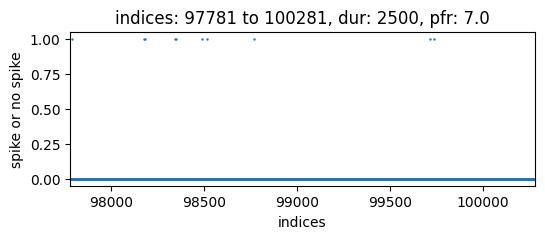

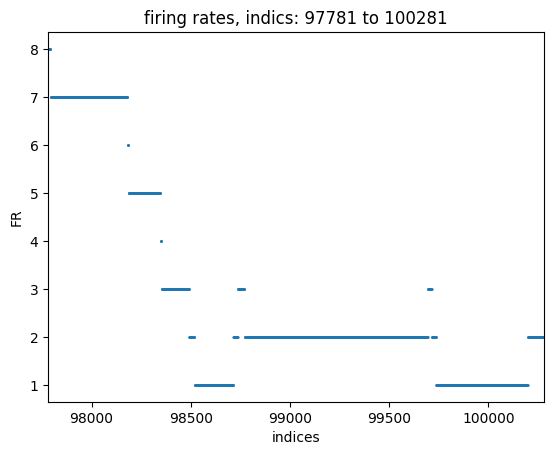

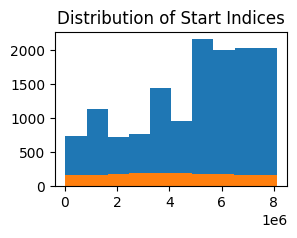

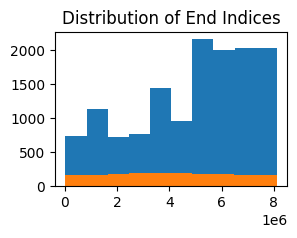

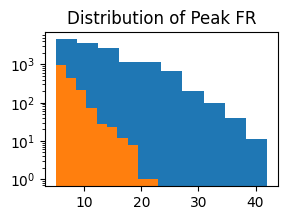

In [206]:
plt.figure(2, (6, 2))
plt.scatter(range(97781, 100281), spikeTrains[1][97781:100281], s=0.5)
plt.title(f"indices: 97781 to 100281, dur: {2500}, pfr: {maxDur_inds[0][3]}")
plt.xlim([97781, 100281])
plt.xlabel("indices")
plt.ylabel("spike or no spike")

plt.figure(3)
plt.scatter(range(97781, 100281), cST[97781:100281], s=0.5)
plt.title(f"firing rates, indics: 97781 to 100281")
plt.xlim([97781, 100281])
plt.xlabel("indices")
plt.ylabel("FR")

plt.figure(0, figsize=(3,2))
plt.hist(othDur_inds[:,0], label="Regular")
plt.hist(maxDur_inds[:,0], label="Long")
plt.title("Distribution of Start Indices")


plt.figure(1, figsize=(3,2))
plt.hist(othDur_inds[:,1], label="Regular")
plt.hist(maxDur_inds[:,1], label="Long")
plt.title("Distribution of End Indices")

plt.figure(4, figsize=(3,2))
plt.hist(othDur_inds[:,3], label="Regular")
plt.hist(maxDur_inds[:,3], label="Long")
plt.title("Distribution of Peak FR")
plt.yscale("log")
# can't have a decimal firing rate I think, so anything with peak fr <= 10, will never see subsequent firing rates go below 1,
# which is greater than or equal to 0.1 of their peak fr

([<matplotlib.axis.XTick at 0x1ff101fcf10>,
 [Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35'),
  Text(40.0, 0, '40'),
  Text(45.0, 0, '45')])

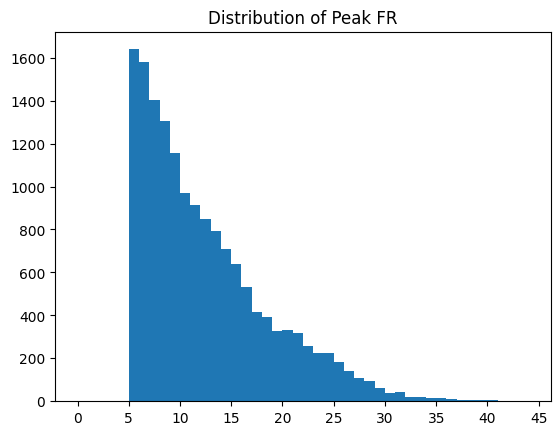

In [224]:
plt.hist(motif_inds[:,3], bins=np.arange(45))
plt.title("Distribution of Peak FR")
plt.xticks(np.linspace(0, 45, 10))

In [63]:
np.shape(maxDur_inds)

(105, 4)

Text(0, 0.5, 'FR')

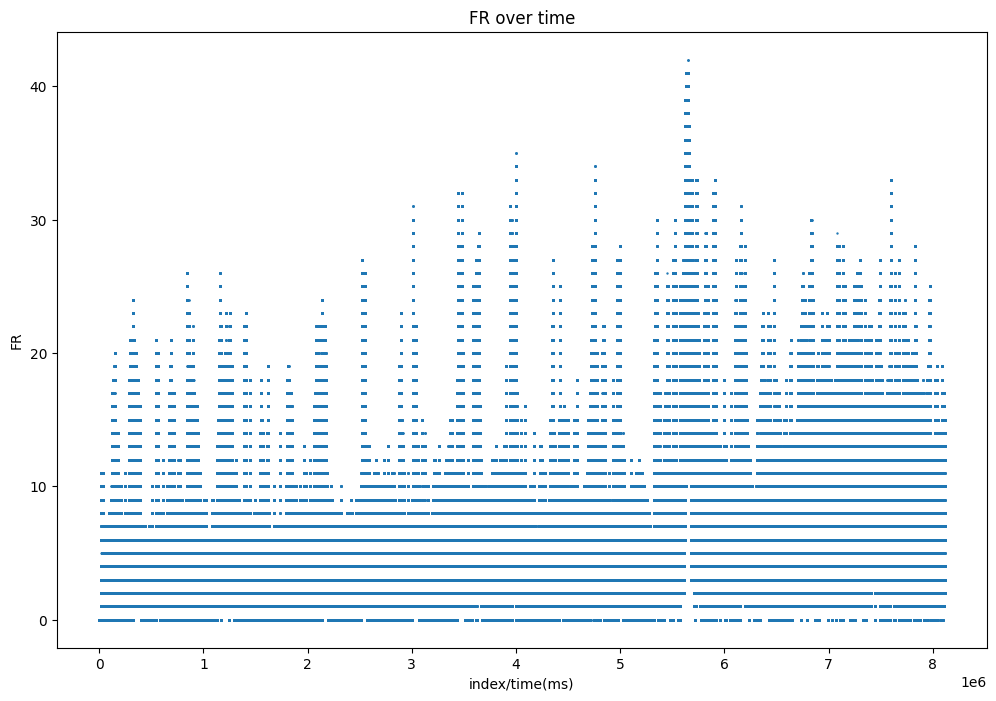

In [142]:
plt.figure(figsize=(12,8))
plt.scatter(range(len(cST)), cST, s=0.5)
plt.title("FR over time")
plt.xlabel("index/time(ms)")
plt.ylabel("FR")

Text(0, 0.5, 'FR')

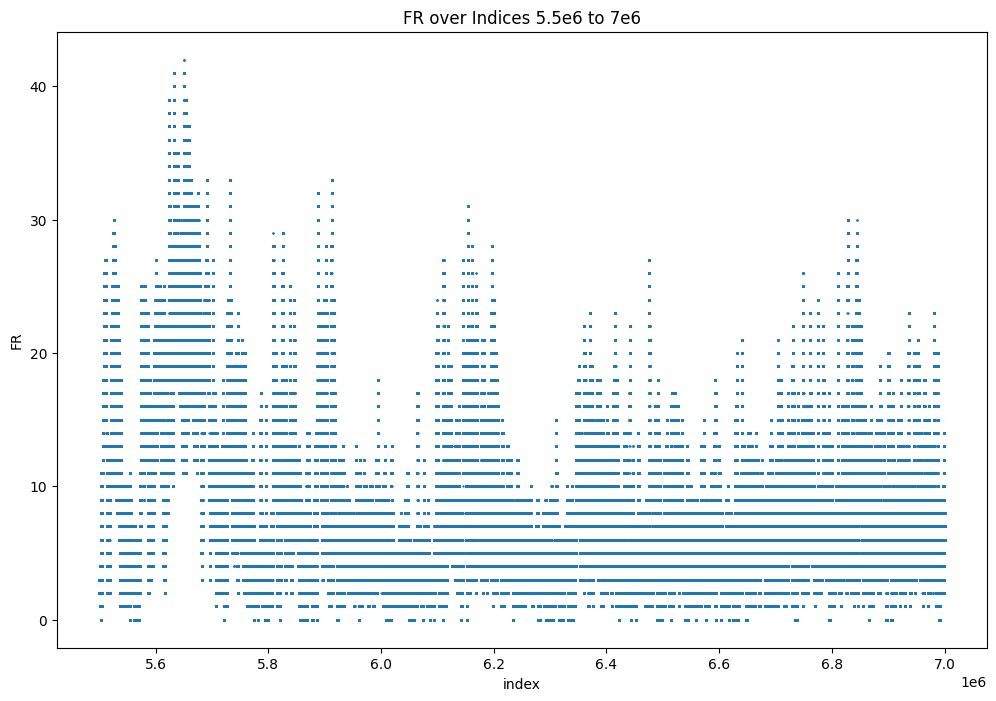

In [149]:
plt.figure(figsize=(12,8))
plt.scatter(range(5500000,7000000), cST[5500000:7000000], s=0.5)
plt.title("FR over Indices 5.5e6 to 7e6")
plt.xlabel("index")
plt.ylabel("FR")

Text(0.5, 1.0, 'Distribution of all FR')

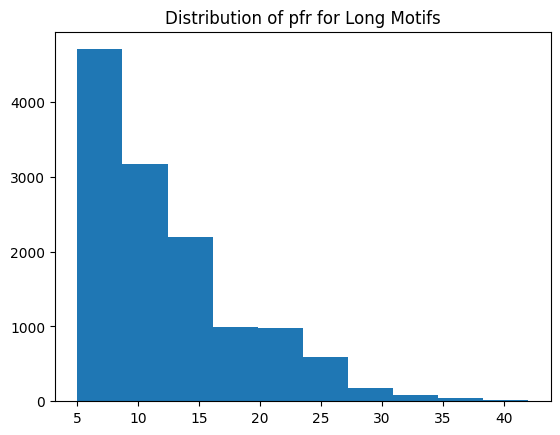

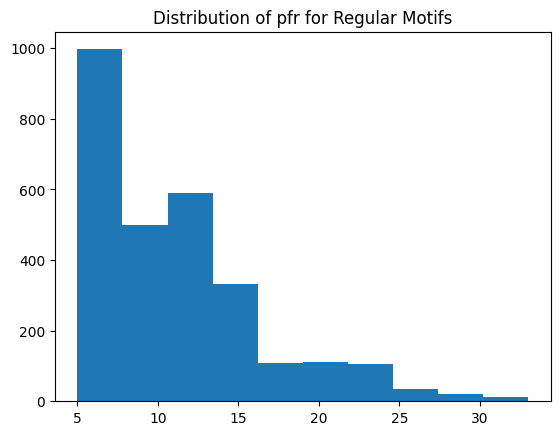

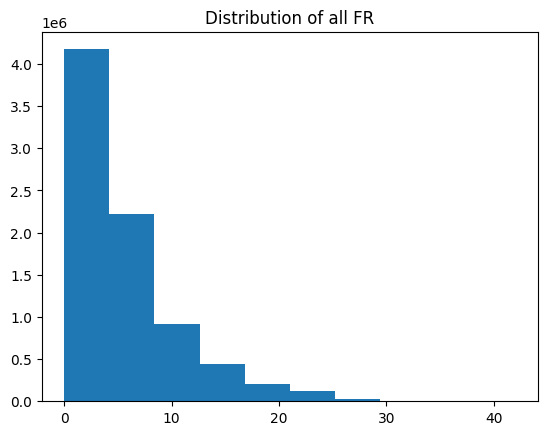

In [133]:
plt.figure(1)
plt.hist(maxDur_inds[:,3])
plt.title("Distribution of pfr for Long Motifs")

plt.figure(2)
plt.hist(othDur_inds[:,3])
plt.title("Distribution of pfr for Regular Motifs")

plt.figure(3)
plt.hist(cST)
plt.title("Distribution of all FR")

In [ ]:
plt.hist(motif_inds[:,2], bins=[300, 325, 350, 375, 400, 425, 500, 525, 600, 625, 700, 725, 800, 825, 12000, 12025])
plt.yscale('log')

##### Distribution of Motif Durations

In [39]:
motifInds_01, maxDurInds_01, othDurInds_01, cST_01 = findMotifs(spikeTrains[0])

entered fn
begin identifying indices of peaks with fr > 5Hz
0.6999664204163868
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 4169


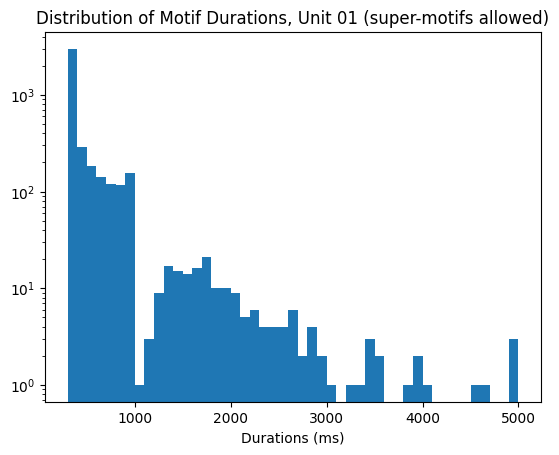

In [42]:
plt.hist(motifInds_01[:,2], bins = np.linspace(300, 5000, 48))
plt.yscale("log")

plt.title("Distribution of Motif Durations, Unit 01 (super-motifs allowed)")
plt.xlabel("Durations (ms)")
plt.savefig("../Figures/motifDurDistr_Unit01_SuperMotifsOk.jpg")

In [53]:
motifInds_02, maxDurInds_02, othDurInds_02, cST_02 = findMotifs(spikeTrains[1])

entered fn
begin identifying indices of peaks with fr > 5Hz
0.9001471047118085
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 20193
0
5048
10096
15144


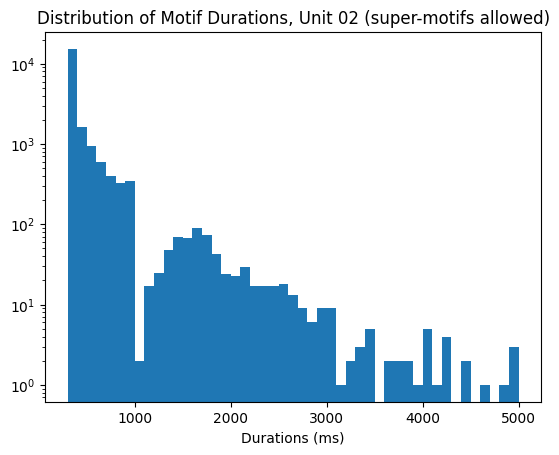

In [54]:
plt.hist(motifInds_02[:,2], bins = np.linspace(300, 5000, 48))
plt.yscale("log")

plt.title("Distribution of Motif Durations, Unit 02 (super-motifs allowed)")
plt.xlabel("Durations (ms)")
plt.savefig("../Figures/motifDurDistr_Unit02_SuperMotifsOk.jpg")

In [55]:
motifInds_03, maxDurInds_03, othDurInds_03, cST_03 = findMotifs(spikeTrains[2])

entered fn
begin identifying indices of peaks with fr > 5Hz
0.4604616371019449
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 4309
0
1077
2154
3231
4308


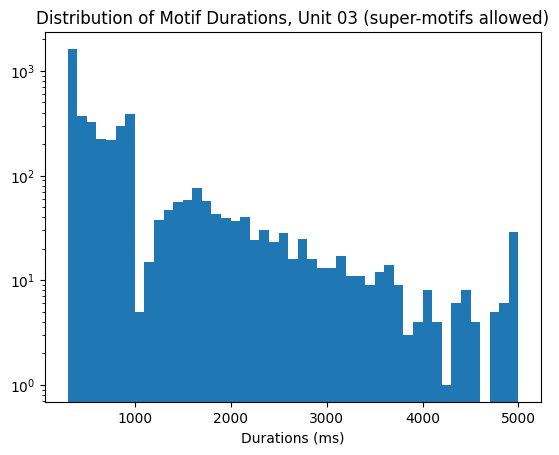

In [57]:
plt.hist(motifInds_03[:,2], bins = np.linspace(300, 5000, 48))
plt.yscale("log")

plt.title("Distribution of Motif Durations, Unit 03 (super-motifs allowed)")
plt.xlabel("Durations (ms)")
plt.savefig("motifDurDistr_Unit03_SuperMotifsOk.jpg")

In [58]:
motifInds_01_noSM, maxDurInds_01_noSM, othDurInds_01_noSM, cST_01_noSM = findMotifs(spikeTrains[0])

entered fn
begin identifying indices of peaks with fr > 5Hz
0.6999664204163868
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 4169
0
1042
2084
3126
4168


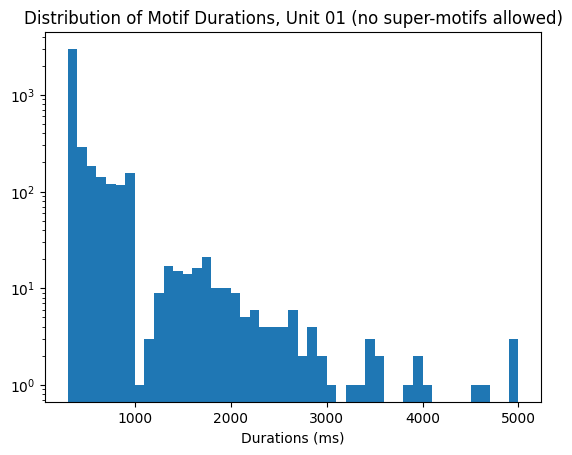

In [59]:
plt.hist(motifInds_01_noSM[:,2], bins = np.linspace(300, 5000, 48))
plt.yscale("log")

plt.title("Distribution of Motif Durations, Unit 01 (no super-motifs allowed)")
plt.xlabel("Durations (ms)")
plt.savefig("motifDurDistr_Unit01_NoSuperMotifs.jpg")

In [60]:
motifInds_02_noSM, maxDurInds_02_noSM, othDurInds_02_noSM, cST_02_noSM = findMotifs(spikeTrains[1])

entered fn
begin identifying indices of peaks with fr > 5Hz
0.9001471047118085
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 20193
0
5048
10096
15144


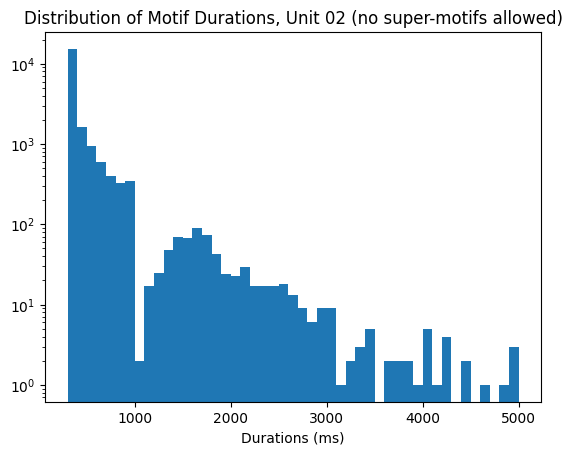

In [61]:
plt.hist(motifInds_02_noSM[:,2], bins = np.linspace(300, 5000, 48))
plt.yscale("log")

plt.title("Distribution of Motif Durations, Unit 02 (no super-motifs allowed)")
plt.xlabel("Durations (ms)")
plt.savefig("motifDurDistr_Unit02_NoSuperMotifs.jpg")

In [62]:
motifInds_03_noSM, maxDurInds_03_noSM, othDurInds_03_noSM, cST_03_noSM = findMotifs(spikeTrains[2])

entered fn
begin identifying indices of peaks with fr > 5Hz
0.4604616371019449
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 4309
0
1077
2154
3231
4308


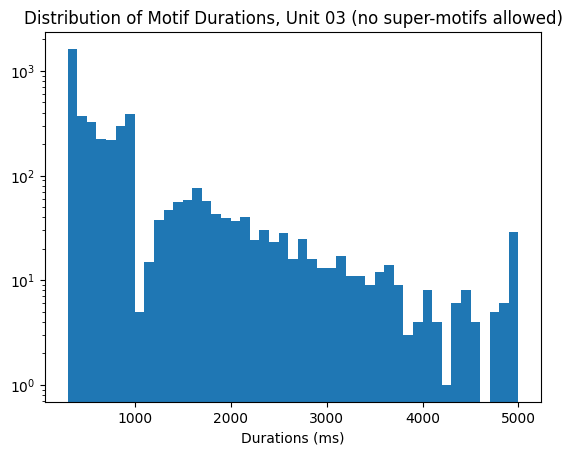

In [63]:
plt.hist(motifInds_03_noSM[:,2], bins = np.linspace(300, 5000, 48))
plt.yscale("log")

plt.title("Distribution of Motif Durations, Unit 03 (no super-motifs allowed)")
plt.xlabel("Durations (ms)")
plt.savefig("motifDurDistr_Unit03_NoSuperMotifs.jpg")

#### Benchmark Motif Detection on Synthetic Data

In [153]:

def findMotifs_fr(cST, peakFR_thresh=5, durs=[300, 325, 350, 375, 400, 500, 600, 700, 800, 1000, 2500], resFRp_thresh=0.1, windowSize=1000): # 
    # first, identify all indices where a peak firing rate of 5 Hz was achieved -> prelim indices
    print("entered fn")

    cST_peaks = find_peaks(cST)[0] # indices of peaks in cST
    indsS = np.array([peak_i for peak_i in cST_peaks if cST[peak_i]>=peakFR_thresh])
    print(len(indsS)/len(cST_peaks))

    # then trim the prelim ind array to include indices where the following 300 indices have a min fr >= 10% of peak fr
    #   for all indices, find the max index value beyond 300 where the min index >= 10% of peak fr
    inds = []
    inds_maxDur = []
    inds_othDur = []
    counter = 0
    
    print("finished identifying indices with fr > 5Hz")
    print("entering loop")
    print(f"total number of loop iterations: {len(indsS)}")
    
    for i in range(len(indsS)):  
        ind = indsS[i]
        resFR_thresh = resFRp_thresh*cST[ind]
        #print(f"resFR_thresh: {resFR_thresh}, resFRp_thresh: {resFRp_thresh}, cST[ind]: {cST[ind]}")

        if ind+durs[0] >= len(cST):
            break
            
        if min(cST[ind+1:ind+durs[0]]) >= resFR_thresh:
            #print(f"condition {min(cST[ind+1:ind+durs[0]])} >= {resFR_thresh} is true")
            startI = ind
            endI = ind+durs[len(durs)-1] # set to max possible value, then update in for loop
            minDur = durs[len(durs)-1]

            # find indices from candidates cST[ind:] that are less that 0.1*cST[ind],
            # else, the lowest index marks the end of the valid motif 
            for j in range(1, len(durs)):
                if (i+1 != len(indsS) and ind+durs[j] > indsS[i+1]) or ind+durs[j] > len(cST) or min(cST[ind+1:ind+durs[j]]) < resFR_thresh: # then this duration doesn't work                    
                    # print(f"entered exit condition, minDur: {durs[j-1]}")
                        
                    endI = ind+durs[j-1]-1
                    minDur = durs[j-1]
                    break
            if minDur == durs[len(durs)-1]:
                inds_maxDur.append((startI, endI, minDur, cST[ind]))
            else:
                inds_othDur.append((startI, endI, minDur, cST[ind]))
            
            inds.append((startI, endI, minDur, cST[ind]))
    # return the trimmed array of indices
    return np.array(inds), np.array(inds_maxDur), np.array(inds_othDur), cST

##### mean 5 Hz sinusoidal firing rate, two peaks

In [154]:
def synMotifDetection(dur = 1, mean_fr = 5, num_peaks = 2):
    cST = np.sin(np.linspace(0, num_peaks*2*np.pi, 1000 * dur)) + mean_fr
    motif_inds, _, _, _ = findMotifs_fr(cST)
    print(f"\nidentified {len(motif_inds)} motifs, at index/indices\n {motif_inds[:,0:2]}")
    plt.plot(cST)

entered fn
1.0
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 1
entered exit condition, minDur: 700

identified 1 motifs, at index/indices
 [[250. 949.]]


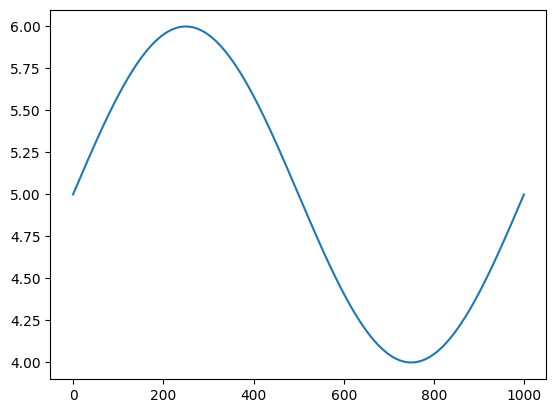

In [120]:
synMotifDetection(num_peaks=1)

entered fn
1.0
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 50
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minDur: 300
entered exit condition, minD

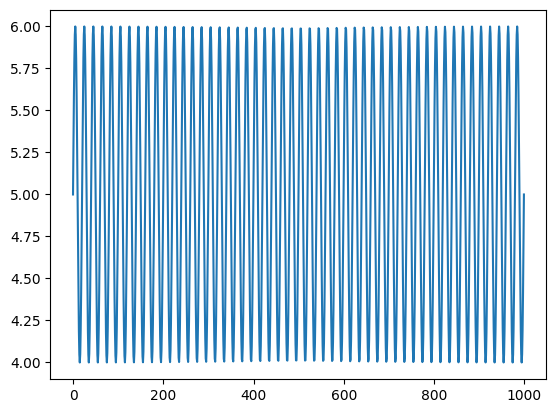

In [121]:
synMotifDetection(num_peaks=50)

##### Add noise

In [159]:
# distribution of firing rate without moving window
# poisson neuron --> choose va lambda with probability proportional to exponentially decreasing
def synMotifDetectionNoise(dur = 1, mean_fr = 5, num_peaks = 2, noise_intensity = 1):
    cST = np.sin(np.linspace(0, num_peaks*2*np.pi, int(1000 * dur))) + mean_fr + noise_intensity * np.random.normal(0,1,int(1000*dur))
    motif_inds, _, _, _ = findMotifs_fr(cST)
    if len(motif_inds) == 0:
        print("identified 0 motifs")
    else:
        print(f"\nidentified {len(motif_inds)} motifs, at index/indices\n {motif_inds[:,0:2]}")
    plt.plot(cST)
    return cST

entered fn
0.5306122448979592
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 52
identified 0 motifs


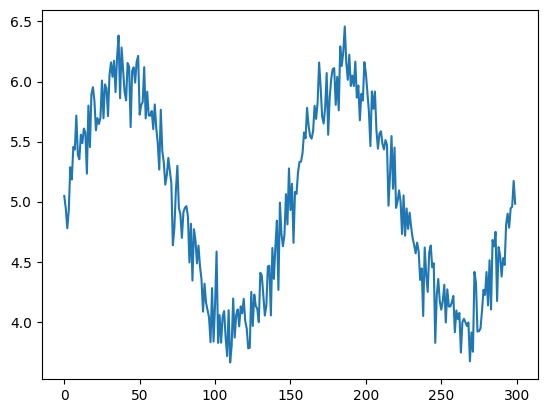

In [160]:
_ = synMotifDetectionNoise(dur=0.3, noise_intensity=0.2)

entered fn
0.5555555555555556
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 70

identified 34 motifs, at index/indices
 [[  2. 301.]
 [  5. 304.]
 [  7. 306.]
 [ 10. 309.]
 [ 21. 320.]
 [ 23. 322.]
 [ 25. 324.]
 [ 29. 328.]
 [ 32. 331.]
 [ 35. 334.]
 [ 40. 339.]
 [ 42. 341.]
 [ 44. 343.]
 [ 47. 346.]
 [ 50. 349.]
 [ 54. 353.]
 [ 56. 355.]
 [ 60. 359.]
 [ 66. 365.]
 [ 70. 369.]
 [ 73. 372.]
 [ 76. 375.]
 [ 79. 378.]
 [ 81. 380.]
 [ 85. 384.]
 [ 92. 391.]
 [ 97. 396.]
 [101. 400.]
 [104. 403.]
 [107. 406.]
 [109. 408.]
 [114. 413.]
 [119. 418.]
 [125. 424.]]


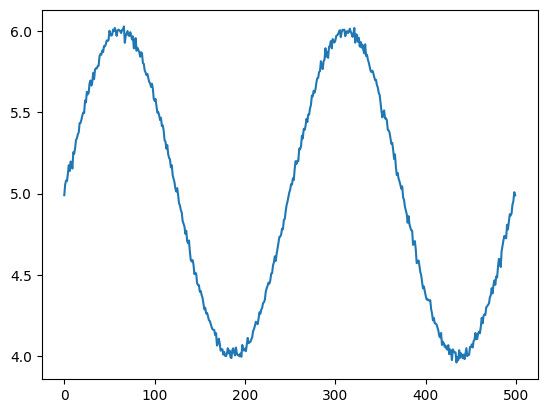

In [163]:
cst_500ms = synMotifDetectionNoise(dur=0.5, noise_intensity=0.02)

Text(0.5, 1.0, 'Sample Firing Rate Array')

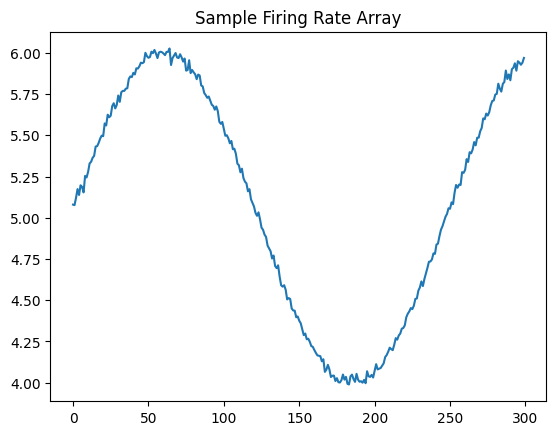

In [175]:
plt.plot(cst_500ms[2:302])
plt.title("Sample Firing Rate Array")

##### Poisson Spike Train

###### Poisson

In [75]:
spikeTime2Train([1, 2, 3, 10, 24, 50])

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [95]:
def genPoissonData(mfr, n_ms, i): # mfr = # spikes per second
    assert(n_ms == max(unitSpikeTimes_whole[i]))
    assert(mfr == sum(spikeTrains[i])/len(spikeTrains[i]) * 1000)
    
    sim = np.random.rand(n_ms,) 
    thresh = 1-mfr/1000
    
    sim_spiketimes = np.array([j for j in range(len(sim)) if sim[j] > thresh]) # thresh(i), fr sin, mean 5, rate range 2.5
    sim_spiketrain = spikeTime2Train(sim_spiketimes)
    
    sim_ISIH = np.diff(sim_spiketimes)

    return sim_spiketimes, sim_spiketrain, sim_ISIH

In [25]:
a = [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1] # find peaks to find indices of 1s
n_spikes = 5

a_inds = [i for i in range(len(a)) if a[i]==1]
print(a_inds)
a_inds[-4:]
for i in a_inds[-4:]:
    a[i] = 0
sum(a)

[0, 2, 3, 4, 5, 6, 8, 9, 11]


5

In [114]:
def genSTr(mfr, n_ms, n_spikes, i):
    assert(n_ms == max(unitSpikeTimes_whole[i]))
    assert(mfr == sum(spikeTrains[i])/len(spikeTrains[i]) * 1000)
    assert(n_spikes == sum(spikeTrains[i]))
    
    flag = True
    
    while flag:
        _, spike_train, _ = genPoissonData(mfr, n_ms, i)
        if sum(spike_train) >= n_spikes:
            flag = False

    one_inds = [i for i in range(len(spike_train)) if spike_train[i]==1]
    print(sum(spike_train)-n_spikes)
    for i in one_inds[-int(sum(spike_train)-n_spikes):]:
        spike_train[i] = 0

    return spike_train

In [92]:
spike_train = [0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
n_spikes = 4
one_inds = [i for i in range(len(spike_train)) if spike_train[i]==1]

print(sum(spike_train))
print(spike_train)
for i in one_inds[-int(sum(spike_train)-n_spikes):]:
    print(i)
    spike_train[i] = 0
    print(spike_train)

sum(spike_train)

6
[0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
6
[0, 1, 1, 1, 0, 1, 0, 0, 1, 0]
8
[0, 1, 1, 1, 0, 1, 0, 0, 0, 0]


4

In [115]:
sim_STrs = []
for i in range(1):
    print(i)
    sim_STrs.append(genSTr(1000*sum(spikeTrains[i])/len(spikeTrains[i]), max(unitSpikeTimes_whole[i]), sum(spikeTrains[i]), i))
    
    assert(sum(sim_STrs[i])==sum(spikeTrains[i])) # test for same num spikes
    #assert(sum(sim_STrs[i])/len(sim_STrs[i]) == sum(spikeTrains[i])/len(spikeTrains[i])) # test for same mfr

0
124.0


In [113]:
sum(spikeTrains[0])

18132.0

In [112]:
sum(sim_STrs[0])

18132.0

In [117]:
len(spikeTrains[0])

8114162

In [118]:
len(sim_STrs[0])

8113965

In [119]:
len(spikeTrains[0])-len(sim_STrs[0])

197

###### Workaround

In [167]:
genSTr(0.8, 10, 8, 0)

array([1., 1., 0., 1., 1., 1., 1., 1., 1., 0.])

In [74]:
def genSTr(mfr, n_ms, n_spikes, i):
    assert(n_ms == max(unitSpikeTimes_whole[i]))          
    assert(mfr == (1000*sum(spikeTrains[i])/len(spikeTrains[i])))
    assert(n_spikes == sum(spikeTrains[i]))
    
    spike_train = np.random.permutation(np.append(np.ones(int(n_spikes)), np.zeros(int(n_ms-n_spikes))))

    return spike_train

In [69]:
sim_STrs = []
for i in range(3):
    print(i)
    sim_STrs.append(genSTr(1000*sum(spikeTrains[i])/len(spikeTrains[i]), max(unitSpikeTimes_whole[i]), sum(spikeTrains[i]), i))
    
    assert(sum(sim_STrs[i])==sum(spikeTrains[i])) # test for same num spikes
    assert(sum(sim_STrs[i])/len(sim_STrs[i]) == sum(spikeTrains[i])/len(spikeTrains[i])) # test for same mfr

0
1.4480141304117335
13862.0
9573111
1
5.0357294358285385
48232.0
9577957
2
2.3729963063987274
22729.0
9578186


In [75]:
motifInds_sim01, _, _, _ = findMotifs(sim_STrs[0])

entered fn
begin identifying indices of peaks with fr > 5Hz
0.08462796402289452
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 621
0
155
310
465
620


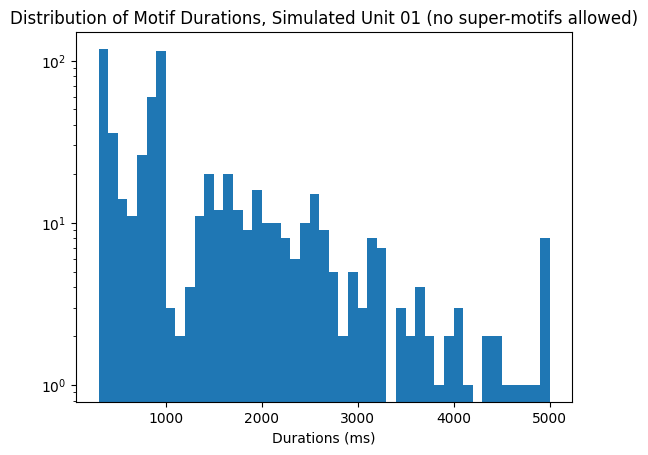

In [76]:
plt.hist(motifInds_sim01[:,2], bins = np.linspace(300, 5000, 48))
plt.yscale("log")

plt.title("Distribution of Motif Durations, Simulated Unit 01 (no super-motifs allowed)")
plt.xlabel("Durations (ms)")
plt.savefig("motifDurDistr_Unit01_Sim_NoSuperMotifs.jpg")

In [77]:
motifInds_sim02, _, _, _ = findMotifs(sim_STrs[1])

entered fn
begin identifying indices of peaks with fr > 5Hz
0.8210644584078898
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 19731
0
4932
9865
14797
19730


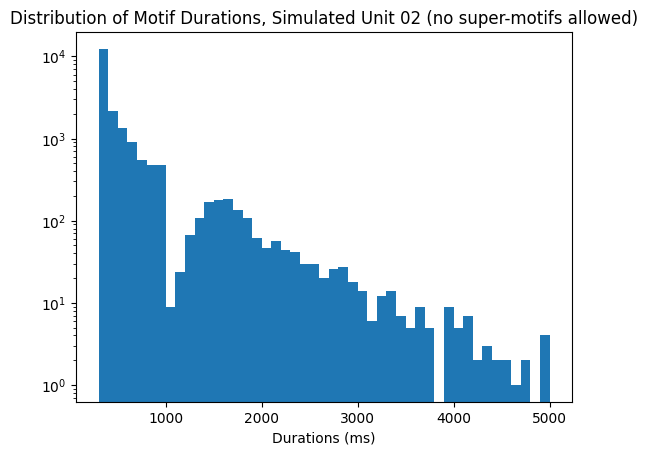

In [78]:
plt.hist(motifInds_sim02[:,2], bins = np.linspace(300, 5000, 48))
plt.yscale("log")

plt.title("Distribution of Motif Durations, Simulated Unit 02 (no super-motifs allowed)")
plt.xlabel("Durations (ms)")
plt.savefig("motifDurDistr_Unit02_Sim_NoSuperMotifs.jpg")

In [79]:
motifInds_sim03, _, _, _ = findMotifs(sim_STrs[2])

entered fn
begin identifying indices of peaks with fr > 5Hz
0.29951859956236326
finished identifying indices with fr > 5Hz
entering loop
total number of loop iterations: 3422
0
855
1710
2565
3421


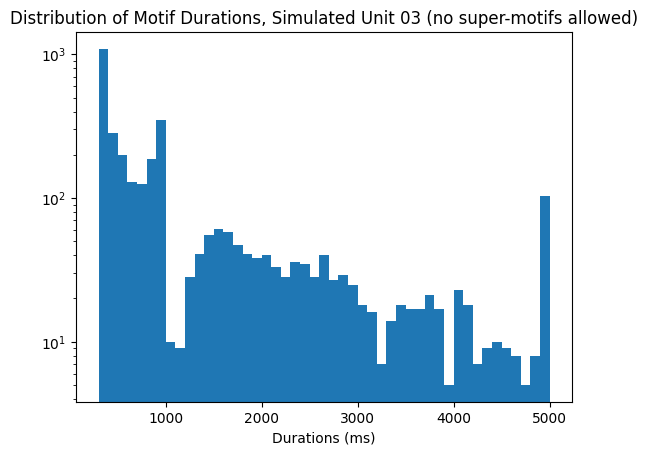

In [80]:
plt.hist(motifInds_sim03[:,2], bins = np.linspace(300, 5000, 48))
plt.yscale("log")

plt.title("Distribution of Motif Durations, Simulated Unit 03 (no super-motifs allowed)")
plt.xlabel("Durations (ms)")
plt.savefig("motifDurDistr_Unit03_Sim_NoSuperMotifs.jpg")

In [160]:
motif_inds_01_noSM.shape

(5574, 4)

In [82]:
ks_2samp(motifInds_01_noSM[:,2], motifInds_sim01[:,2])

KstestResult(statistic=0.574552067267451, pvalue=1.3003161834260804e-167, statistic_location=600.0, statistic_sign=1)

In [83]:
ks_2samp(motifInds_02_noSM[:,2], motifInds_sim02[:,2])

KstestResult(statistic=0.13168875103883104, pvalue=2.3314949199927357e-151, statistic_location=300.0, statistic_sign=1)

In [84]:
ks_2samp(motifInds_03_noSM[:,2], motifInds_sim03[:,2])

KstestResult(statistic=0.12107255429795791, pvalue=8.2111560726731e-25, statistic_location=800.0, statistic_sign=1)

### Plot kymographs of motifs

### Poisson Surprise

In [63]:
sim = np.random.rand(max(unitSpikeTimes_whole[0]),) 
mfr = sum(spikeTrains[0])/len(spikeTrains[0]) * 1000
thresh = 1-mfr/1000

sim_spiketimes = [j for j in range(len(sim)) if sim[j] > thresh] # thresh(i), fr sin, mean 5, rate range 2.5
sim_spiketrain = spikeTime2Train(sim_spiketimes)

sim_ISIH = np.diff(sim_spiketimes)

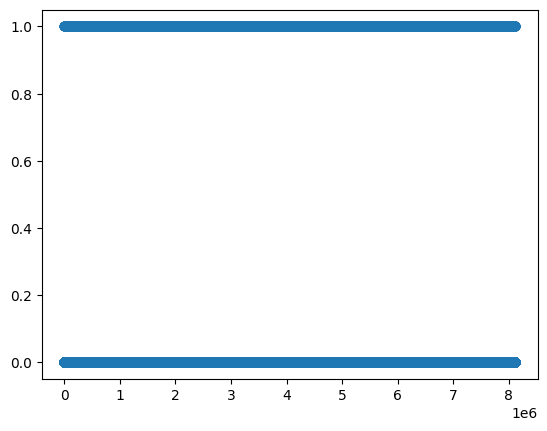

In [39]:
plt.scatter(np.arange(len(sim_spiketrain)), sim_spiketrain)

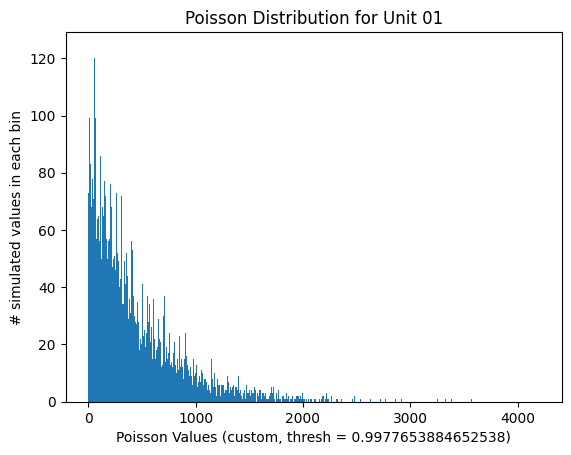

In [14]:
plt.hist(sim_ISIH, bins=len(np.unique(sim_ISIH)))
plt.xlabel(f"Poisson Values (custom, thresh = {thresh})")
plt.ylabel("# simulated values in each bin")
plt.title(f"Poisson Distribution for Unit 01")
plt.savefig(f"PoissonDistr-thresh0998-Unit01.png")

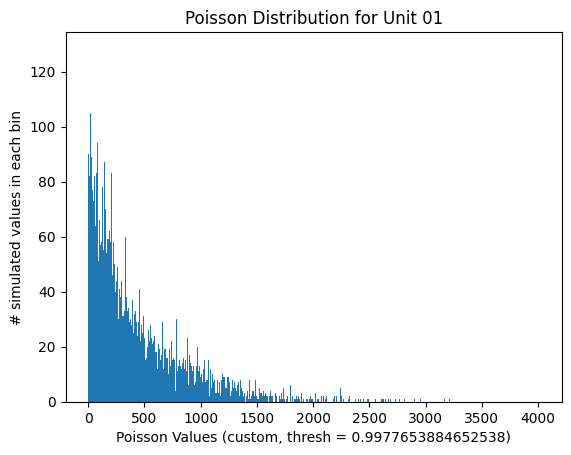

In [64]:
plt.hist(sim_ISIH, bins=len(np.unique(sim_ISIH)))
plt.xlabel(f"Poisson Values (custom, thresh = {thresh})")
plt.ylabel("# simulated values in each bin")
plt.title(f"Poisson Distribution for Unit 01")
plt.savefig(f"PoissonDistr-thresh0998-Unit01.png")